In [1]:
using Gen
using PyPlot

Set the seed so the notebook results are reproducible:

In [2]:
srand(1);

# Probabilistic programs in Gen

We begin by learning to use Gen to write probabilistic models. In Gen, probabilistic models are represented as *probabilistic programs*. The random choices used inside a probabilistic program are called the *trace* of the program.

### Writing a probabilistic program
A probabilistic program in Gen is simply a Julia function whose first argument is `T::Trace`, and in which random choices have been tagged with names using the `~` syntax:

In [3]:
function sprinkler_model(T::Trace)
     cloudy = flip(0.5) ~ "cloudy"
     sprinkler = flip(cloudy ? 0.1 : 0.5) ~ "sprinkler"
     rain = flip(cloudy ? 0.8 : 0.2) ~ "rain"
     wetgrass = flip(
         if sprinkler
             rain ? 0.99 : 0.9
         else
             rain ? 0.9 : 0.01
         end) ~ "wetgrass"
end

sprinkler_model (generic function with 1 method)

### Tracing a probabilistic program
We run a probabilistic program by passing in a `Trace` object. When the program is run, it records the value of each named random choice into the dictionary `T.vals`:

In [4]:
sprinkler_trace = Trace()
sprinkler_model(sprinkler_trace)

true

We can now inspect the trace:

In [5]:
cloudy = sprinkler_trace.vals["cloudy"]
sprinkler = sprinkler_trace.vals["sprinkler"]
rain = sprinkler_trace.vals["rain"]
wetgrass = sprinkler_trace.vals["wetgrass"]
println("cloudy=$cloudy") # NOTE Julia's string interpolation syntax
println("sprinkler=$sprinkler")
println("rain=$rain")
println("wetgrass=$wetgrass")

cloudy=true
sprinkler=false
rain=true
wetgrass=true


### Problem 1.1
List all possible traces for the `sprinker_model` program above, and the probability for each trace. Check that they sum to 1.0. Feel free to generate
the list programatically.

In [6]:
# ANSWER HERE

### Problem 1.2
Give a directed acyclic graph (DAG) expressing the conditional independencies between random choices in the above `sprinkler_model` program (i.e. the Bayesian network for the probabilistic model). Specify the DAG by its vertices and edges.

In [7]:
# ANSWER HERE

### A program with an unbounded number of random choices
Here is a program with an unbounded number of random choices:

In [8]:
function foo(T::Trace, n::Int)
    if (flip(0.5) ~ "flip-$n")
        foo(T, n + 1)
    else
        n
    end
end

function recursion_program(T::Trace)
    return foo(T,0)
end

recursion_program (generic function with 1 method)

Note that probabilitsic programs can use sub-routines, and these sub-routines can have traced random choices, along as they also have the T::Trace as their first argument

In [9]:
# One traced execution of recursion_program
println("\nFirst execution")
recursion_trace = Trace()
return_value = recursion_program(recursion_trace)
for key in keys(recursion_trace.vals)
    println("$key=$(recursion_trace.vals[key])")
end
println("return-value=$return_value")

# Another traced execution
println("\nSecond execution")
recursion_trace = Trace() 
return_value = recursion_program(recursion_trace)
for key in keys(recursion_trace.vals)
    println("$key=$(recursion_trace.vals[key])")
end
println("return-value=$return_value")



First execution
flip-2=false
flip-1=true
flip-0=true
return-value=2

Second execution
flip-0=false
return-value=0


Note that the number of random choices that were sampled is different between the two executions. Unlike Bayesian networks, probabilistic programs can represent models in which (1) the set of which random choices are sampled is itself a random object, and (2) the set of random choices is potentially countably infinite.

We next perform 20 independent traced executions of the program, and list the value of the return value in each.

In [10]:
return_values = []
for i=1:20
    push!(return_values, recursion_program(Trace()))
end
println("return values: $return_values")

return values: Any[1,0,2,5,1,0,1,0,1,1,3,1,3,1,0,2,0,0,1,2]


Probabilistic programs are regular Julia functions, and can can be parameterized by adding function parameters. Here, we parameterize the recursion_program by the probability of each flip resulting in heads, and run it again:

In [11]:
function foo(T::Trace, n::Int, prob_heads::Float64)
    if (flip(prob_heads) ~ "flip_$n")
        foo(T, n + 1)
    else
        n
    end
end

function recursion_program(T::Trace, prob_heads::Float64)
    return foo(T,0, prob_heads)
end

return_values = []
for i=1:20
    push!(return_values, recursion_program(Trace(), 0.1))
end
println("return values: $return_values")

return values: Any[0,1,2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0]


Unsurprisingly, changing that parameter has a pretty drastic effect on the distribution of return values.

## Problem 1.3

Recall that a trace is the set of random choices and their values.

(a) List the set of possible traces for the recursion_example program above, the probability of each possible trace, and the value of output for each trace. Do the probabilities sum to 1?

(b) Describe the marginal distribution of output.

(c) Can you draw a Bayesian network corresponding to `recursion_program`?

In [12]:
# ANSWER HERE

Consider the probabilistic program `shared_or_separate` below. Note that we have parameterized this program by a `num_obs` parameter. Also note that we do not name all of the random choices. In Gen, not all random choices need to be named.

In [20]:
function shared_or_separate(T::Trace, num_obs::Int)
    mean_shared = normal(0., 10.)
    mean_1 = normal(0., 10.)
    mean_2 = normal(0., 10.)
    variance = Gen.gamma(1., 1.)
    shared = flip(0.2) ~ "shared"
    outputs = []
    for i=1:num_obs
        if i < num_obs / 2
            # cohort 1 (first half of data points)
            if shared
                mu = mean_shared
            else
                mu = mean_1
            end
        else
            # cohort 2 (second half of data points)
            if shared
                mu = mean_shared
            else
                mu = mean_2
            end
        end
        push!(outputs, normal(mu, sqrt(variance)) ~ "output-$i")
    end
    return outputs
end

shared_or_separate (generic function with 1 method)

Below, we run this program many times, and plot the histogram of the outputs for each run. We use PyPlot which is a Julia package that wraps Python's matplotlib module.

In [36]:
all_outputs = []
for replicate=1:24
    outputs = shared_or_separate(Trace(), 50)
    push!(all_outputs, outputs)
end

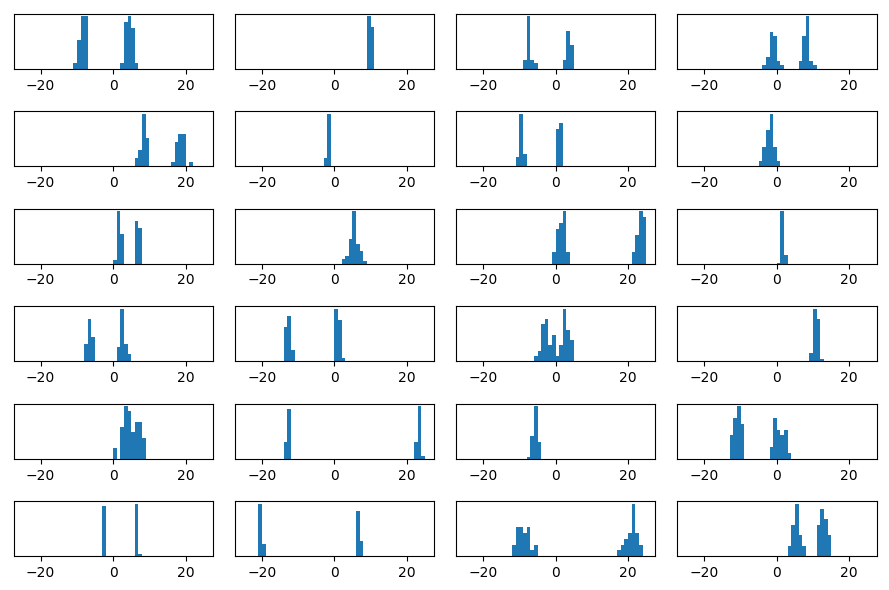

In [37]:
plt[:figure](figsize=(9, 6))
for (i, outputs) in enumerate(all_outputs)
    plt[:subplot](6, 4, i)
    plt[:hist](outputs, bins=50, range=(-25, 25))
    ax = plt[:gca]()
    plt[:gca]()[:get_yaxis]()[:set_visible](false)
end
plt[:tight_layout]()

## Problem 1.4

(a) Describe what the `shared_or_separate` program above is doing, and a possible use of this program as a probabilistic model of data.

(b) Run a new experiment where you extract the value of `shared` for each run of the program, and and use the value of `shared` to improve the histogram, by coloring the runs for which `shared=true` differently fromthe renderings for which `shared=false`.

In [33]:
# ANSWER HERE

The probabilistic program below defines a Bayesian linear regression model.

In [49]:
function linear_regression(T::Trace, xs::Array{Float64,1})
    slope = normal(0., 2.) ~ "slope"
    intercept = normal(0., 2.) ~ "intercept"
    variance = 1.0
    line = (x::Float64) -> intercept + slope * x
    ys = map(
            (i) -> normal(line(xs[i]), variance) ~ "y$i", 
            1:length(xs))
end

linear_regression (generic function with 2 methods)

In [50]:
trace = Trace()
linear_regression(trace, [-3., -2., -1., 0., 1., 2., 3.])
for key in keys(trace.vals)
    println("$key=$(trace.vals[key])")
end

slope=0.4690200321133274
intercept=2.5987900866891533
y3=1.6752952399466634
y1=0.04091201659045951
y4=3.368026487106907
y2=1.4418990118654262
y7=4.809364606726625
y6=3.563151981558405
y5=3.173708861887837


Let's visualize the traces for many repeated executions. We will visualize the `slope` and `intercept` by plotting the corresponding line, and we will scatterplot the x, y pairs. We visualize a trace by writing a *trace rendering* function, that takes a trace and any other input parameters as arguments and draws a plot onto the current axis.

In [93]:
traces = []
xs = collect(linspace(-5.0, 5.0, 20))
for replicate=1:36
    trace = Trace()
    linear_regression(trace, xs)
    push!(traces, trace)
end

In [94]:
function render_linear_regression_trace(trace::Trace,
                                         xs::Array{Float64,1},
                                         ax, xlim, ylim)
    slope = trace.vals["slope"]
    intercept = trace.vals["intercept"]
    ys = map((i) -> trace.vals["y$i"], 1:length(xs))
    ax[:scatter](xs, ys, lw=0, s=50)
    ax[:plot](xlim, slope * xlim + intercept, color="green", lw=4)
    ax[:set_xlim](xlim)
    ax[:set_ylim](ylim)
end

render_linear_regression_trace (generic function with 1 method)

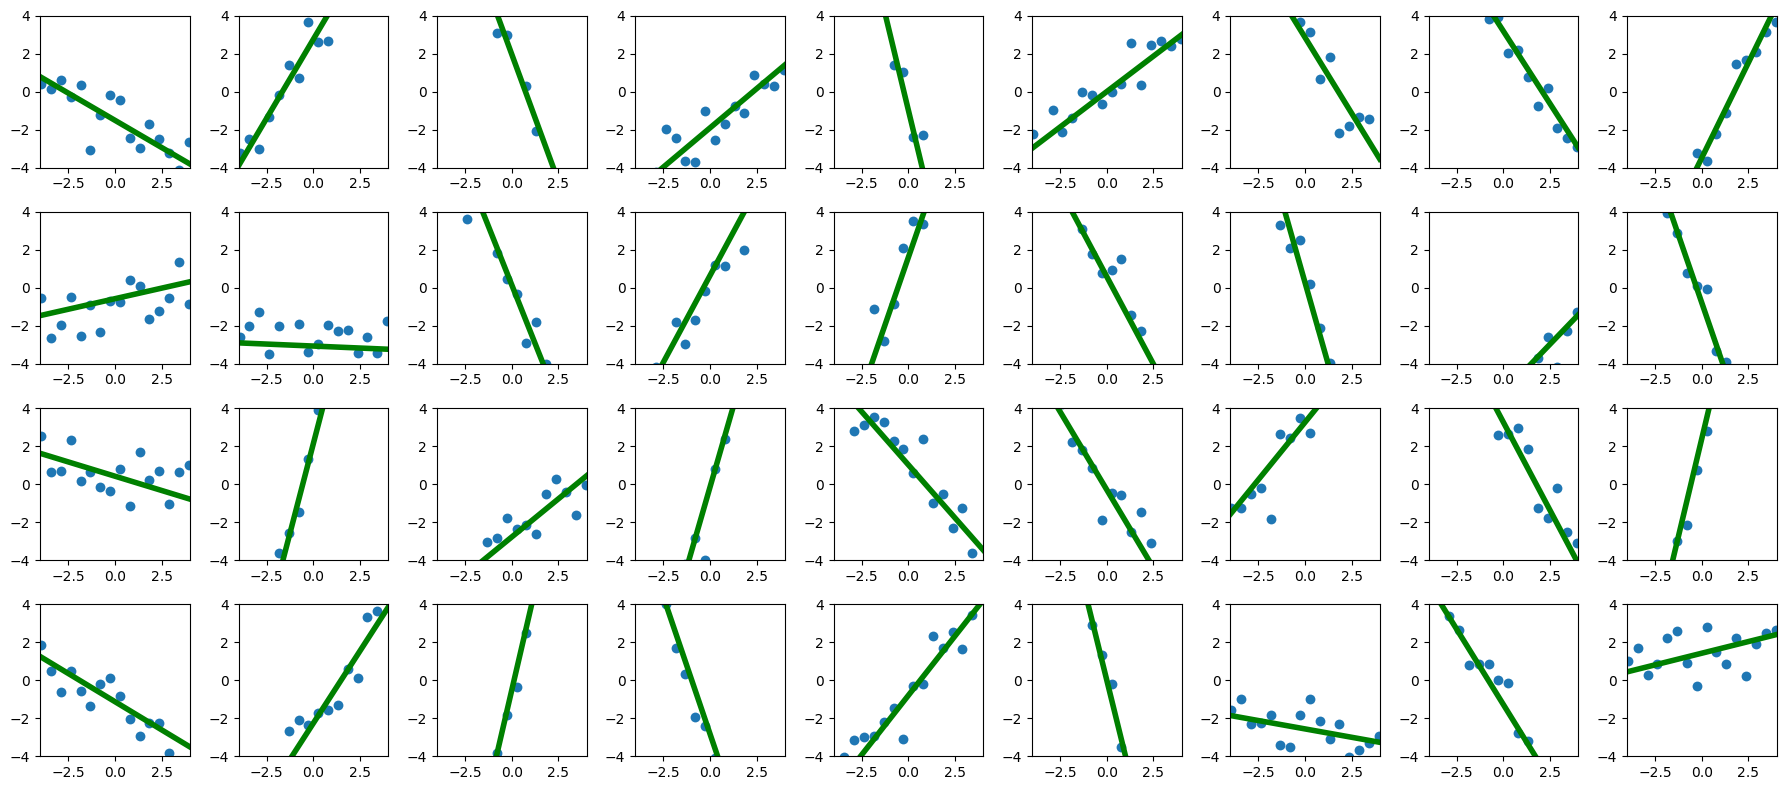

In [95]:
plt[:figure](figsize=(18, 8))
for (i, trace) in enumerate(traces)
    plt[:subplot](4, 9, i)
    ax = plt[:gca]()
    xlim = [-4., 4.]
    ylim = [-4., 4.]
    render_linear_regression_trace(trace, xs, ax, xlim, ylim)
end
plt[:tight_layout]()

## Problem 1.5

Run a number of traced executions of `linear_regression` with modified inputs, render the outputs, and describe how your change affects the prior distribution on traces. For example, what happens if you increase the variance of the prior on the slope?

In [96]:
# ANSWER HERE

The program below shows an extended version of the linear regression model, where each data point may be an outlier or an inlier.

In [97]:
function linear_regression_outliers(T::Trace, xs::Array{Float64,1})
    inlier_noise = gamma(1., 1.) ~ "inlier_noise"
    outlier_noise = 10.0
    prob_outlier = 0.1
    slope = normal(0.0, 2.0) ~ "slope"
    intercept = normal(0.0, 2.0) ~ "intercept"
    ys = Array{Float64, 1}(length(xs))
    for i=1:length(xs)
        y_mean = intercept + slope * xs[i]
        noise = (flip(prob_outlier) ~ "o$i") ? outlier_noise : inlier_noise 
        ys[i] = normal(y_mean, noise) ~ "y$i"
    end
end


linear_regression_outliers (generic function with 2 methods)

We write a new trace rendering for it that shows the outlier data points in red, and shows the value of `inlier_noise` using error bars above and below the line.

In [101]:
function render_linear_regression_outliers_trace(trace::Trace,
                                                 xs::Array{Float64,1},
                                                 ax, xlim, ylim)
    slope = trace.vals["slope"]
    intercept = trace.vals["intercept"]
    ys = map((i) -> trace.vals["y$i"], 1:length(xs))
    outlier_statuses = map((i) -> trace.vals["o$i"], 1:length(xs))
    inlier_noise = trace.vals["inlier_noise"]
    colors = map((i) -> outlier_statuses[i] ? "red" : "blue", 1:length(xs))
    ax[:scatter](xs, ys, lw=0, s=50, c=colors)
    line = intercept + slope * xlim
    ax[:plot](xlim, slope * xlim + intercept, color="green", lw=4)
    plt[:fill_between](xlim, line - inlier_noise, line, color="black", alpha=0.3)
    plt[:fill_between](xlim, line, line + inlier_noise, color="black", alpha=0.3)
    ax[:set_xlim](xlim)
    ax[:set_ylim](ylim)
end

render_linear_regression_outliers_trace (generic function with 1 method)

In [102]:
traces = []
xs = collect(linspace(-5.0, 5.0, 20))
for replicate=1:36
    trace = Trace()
    linear_regression_outliers(trace, xs)
    push!(traces, trace)
end

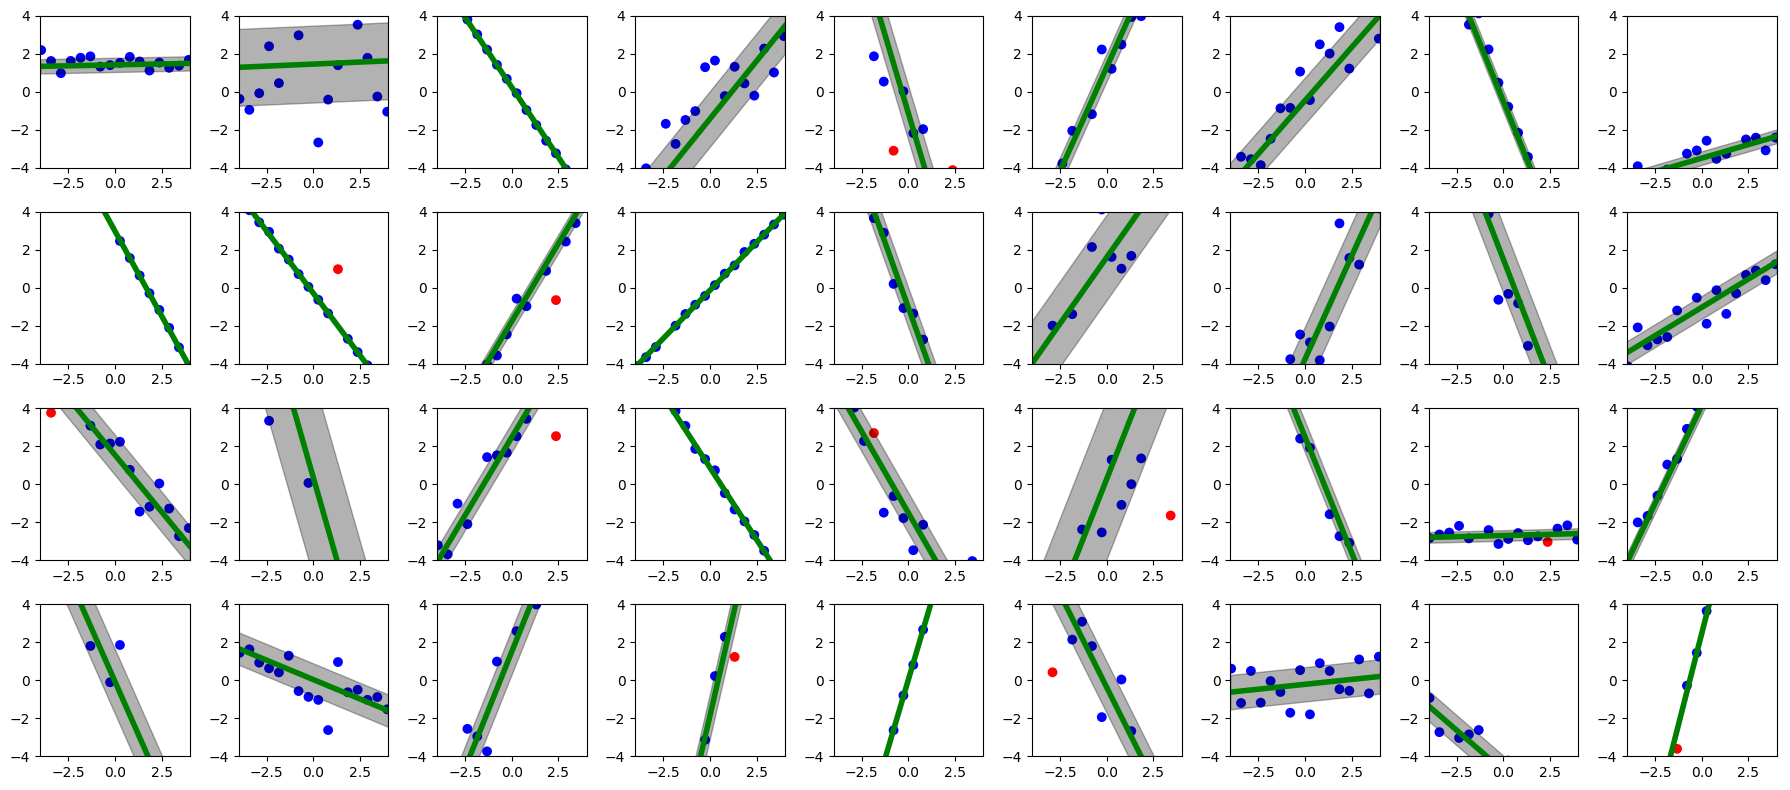

In [103]:
plt[:figure](figsize=(18, 8))
for (i, trace) in enumerate(traces)
    plt[:subplot](4, 9, i)
    ax = plt[:gca]()
    xlim = [-4., 4.]
    ylim = [-4., 4.]
    render_linear_regression_outliers_trace(trace, xs, ax, xlim, ylim)
end
plt[:tight_layout]()

Now you understand how to write probabilistic models in Gen, and how to understand their behavior by visualizing simulations from the models. Next, we will show how to perform approximate probabilistic inference in Gen.